# Example Calculation for Fixed Point Tracking via Pseudo-Arclength Continuation
### Here, we present an example of fixed point tracking on Example 2, a Raoult's Law model on three components (Benzene, Toluene, Zylene).

#### Step 1: Import the necessary packages

In [32]:
import numpy as np
from scipy.optimize import fsolve

import matplotlib.pyplot as plt

from thermo_models.RaoultsLawModel import RaoultsLawModel
from utils.AntoineEquation import AntoineEquationBase10
from distillation.DistillationTernary import DistillationModelTernary

from PIL import Image

#### Step 2: Define the Raoult's law model `RaoultsLawModel` as well as the Ternary Distillation Model `DistillationModelTernary`

In [3]:
# Antoine Parameters for benzene
Ben_A = 4.72583
Ben_B = 1660.652
Ben_C = -1.461

# Antoine Parameters for toluene
Tol_A = 4.07827
Tol_B = 1343.943
Tol_C = -53.773

# Antoine Parameters for Xylene
Xyl_A = 4.14553
Xyl_B = 1474.403
Xyl_C = -55.377

P_sys = 1.0325
# Create Antoine equations for benzene and toluene
benzene_antoine = AntoineEquationBase10(Ben_A, Ben_B, Ben_C)
toluene_antoine = AntoineEquationBase10(Tol_A, Tol_B, Tol_C)
xylene_antoine = AntoineEquationBase10(Xyl_A, Xyl_B, Xyl_C)


xF = np.array([0.3, 0.3, 0.4])
xD = np.array([0.990, 0.0100, 1e-10])
xB = np.array([1e-5, 0.4261,0.5749])
r = 0 # starting value

vle_model = RaoultsLawModel(3,P_sys, '', [benzene_antoine, toluene_antoine, xylene_antoine])
distillation_model = DistillationModelTernary(vle_model, xF = xF, xD = xD, xB = xB, reflux = r)

#### Step 3: Define the equations for pseudo-arclength continuation

In [10]:
# u1 = x1, u2 = x2
def eqns(uvec, l, strip):
    u1 = uvec[0]; u2 = uvec[1]
    res = np.zeros(2)

    thermo_sol = distillation_model.thermo_model.convert_x_to_y(np.array([u1, u2, 1-u1-u2]))[0]
    if strip:
        op_sol = distillation_model.set_r(l).stripping_step_xtoy(np.array([u1, u2, 1-u1-u2]))
    else:
        op_sol = distillation_model.set_r(l).rectifying_step_xtoy(np.array([u1, u2, 1-u1-u2]))

    res[0] = thermo_sol[0] - op_sol[0]
    res[1] = thermo_sol[1] - op_sol[1]

    return res

def eqns_aug(uvec, tau, ds, u0, strip):
    l         = uvec[-1]
    res       = np.zeros_like(uvec)
    res[0:-1] = eqns(uvec[:-1], l, strip=strip)
    res[-1]   = ((uvec[0] - u0[0])*tau[0]) + ((uvec[1] - u0[1])*tau[1]) + ((uvec[2] - u0[2])*tau[2]) - ds

    return res

def arclength_cont(ds, num_steps, lam_m1, old_sol_m1, lam_0, old_sol, strip):
    u1_sol = np.zeros((num_steps))
    u2_sol = np.zeros((num_steps))
    l_sol  = np.zeros((num_steps))

    for i in range(num_steps):
        if i % 1000 == 0:
            print(f'Iteration {i}: composition: {old_sol[0]:.3f}, {old_sol[1]:.3f}, {1-np.sum(old_sol):.3f}, l: {lam_0:.3f}')
        
        del_s = ds

        # Approximation from eqn 8 of Laing
        tau       = np.array([ (old_sol[0] - old_sol_m1[0])/del_s, (old_sol[1] - old_sol_m1[1])/del_s, (lam_0 - lam_m1)/del_s  ])

        prev_sol    = np.array([old_sol[0], old_sol[1], lam_0])
        
        # fsolve is a corrector
        new_sol     = fsolve(eqns_aug, x0 = prev_sol + ds*tau, args = (tau, ds, prev_sol, strip))
        
        # Edit the variables that hold the two prior solutions
        lam_m1, lam_0 = lam_0, new_sol[-1]
        old_sol_m1 = np.copy(old_sol)
        old_sol    = np.copy(new_sol[:-1])

        if abs(lam_m1 - lam_0) > 1:
            break
        
        u1_sol[i] = old_sol[0]
        u2_sol[i] = old_sol[1]
        l_sol[i] = lam_0

    return u1_sol, u2_sol, l_sol

#### Step 4: Tracking the first stripping line fixed points

In [6]:
ds = 0.001
num_steps = 50000
lam_m1 = 0.7427975945893878
old_sol_m1 = fsolve(eqns, x0=np.array([0.18010871121841818, 0.4180232107502042]), args=(lam_m1, True))
lam_0 = lam_m1 + ds
old_sol = fsolve(eqns, x0=old_sol_m1, args=(lam_0, True))

x1s_u1, x1s_u2, x1s_l = arclength_cont(ds,
                                      num_steps,
                                      lam_m1,
                                      old_sol_m1,
                                      lam_0,
                                      old_sol,
                                      strip=True)

Iteration 0: composition: 0.180, 0.418, 0.402, l: 0.744
Iteration 1000: composition: 0.349, 0.331, 0.320, l: 1.726
Iteration 2000: composition: 0.460, 0.274, 0.265, l: 2.718
Iteration 3000: composition: 0.539, 0.234, 0.227, l: 3.715
Iteration 4000: composition: 0.598, 0.204, 0.198, l: 4.713
Iteration 5000: composition: 0.643, 0.181, 0.176, l: 5.712
Iteration 6000: composition: 0.680, 0.162, 0.158, l: 6.712
Iteration 7000: composition: 0.709, 0.147, 0.143, l: 7.712
Iteration 8000: composition: 0.734, 0.135, 0.131, l: 8.712
Iteration 9000: composition: 0.754, 0.124, 0.121, l: 9.712
Iteration 10000: composition: 0.772, 0.115, 0.112, l: 10.712
Iteration 11000: composition: 0.787, 0.108, 0.105, l: 11.712
Iteration 12000: composition: 0.801, 0.101, 0.098, l: 12.713
Iteration 13000: composition: 0.813, 0.095, 0.092, l: 13.713
Iteration 14000: composition: 0.823, 0.089, 0.087, l: 14.713
Iteration 15000: composition: 0.833, 0.085, 0.083, l: 15.714
Iteration 16000: composition: 0.841, 0.080, 0.0

#### Step 5: Tracking the first rectifying line fixed points

In [11]:
ds = 0.001
num_steps = 50000
lam_m1 = 0.001
old_sol_m1 = fsolve(eqns, x0=np.array([0.001, 0.001]), args=(lam_m1, False))
lam_0 = lam_m1 + ds
old_sol = fsolve(eqns, x0=old_sol_m1, args=(lam_0, False))

x2r_u1, x2r_u2, x2r_l = arclength_cont(ds,
                                       num_steps,
                                       lam_m1,
                                       old_sol_m1,
                                       lam_0,
                                       old_sol,
                                       strip=False)

Iteration 0: composition: 0.974, 0.026, -0.000, l: 0.002
Iteration 1000: composition: 0.693, 0.307, -0.000, l: 0.878
Iteration 2000: composition: 0.377, 0.623, 0.000, l: 1.763
Iteration 3000: composition: 0.249, 0.751, 0.000, l: 2.746
Iteration 4000: composition: 0.185, 0.815, 0.000, l: 3.741
Iteration 5000: composition: 0.147, 0.853, 0.000, l: 4.740
Iteration 6000: composition: 0.122, 0.878, 0.000, l: 5.739
Iteration 7000: composition: 0.104, 0.896, -0.000, l: 6.739
Iteration 8000: composition: 0.091, 0.909, 0.000, l: 7.739
Iteration 9000: composition: 0.081, 0.919, 0.000, l: 8.739
Iteration 10000: composition: 0.073, 0.927, -0.000, l: 9.739
Iteration 11000: composition: 0.066, 0.934, 0.000, l: 10.739
Iteration 12000: composition: 0.061, 0.939, -0.000, l: 11.739
Iteration 13000: composition: 0.056, 0.944, -0.000, l: 12.739
Iteration 14000: composition: 0.052, 0.948, 0.000, l: 13.739
Iteration 15000: composition: 0.048, 0.952, 0.000, l: 14.739
Iteration 16000: composition: 0.045, 0.955

#### Step 6: Tracking the second recifying line fixed points

In [28]:
ds = -0.001
num_steps = 39500
lam_m1 = 40
old_sol_m1 = fsolve(eqns, x0=np.array([0, 0]), args=(lam_m1, False))
lam_0 = lam_m1 + ds
old_sol = fsolve(eqns, x0=old_sol_m1, args=(lam_0, False))

x3r_u1, x3r_u2, x3r_l = arclength_cont(ds,
                                       num_steps,
                                       lam_m1,
                                       old_sol_m1,
                                       lam_0,
                                       old_sol,
                                       strip=False)

Iteration 0: composition: 0.007, 0.000, 0.993, l: 39.999
Iteration 1000: composition: 0.007, 0.000, 0.993, l: 38.999
Iteration 2000: composition: 0.007, 0.000, 0.993, l: 37.999
Iteration 3000: composition: 0.007, 0.000, 0.992, l: 36.999
Iteration 4000: composition: 0.007, 0.000, 0.992, l: 35.999
Iteration 5000: composition: 0.008, 0.000, 0.992, l: 34.999
Iteration 6000: composition: 0.008, 0.000, 0.992, l: 33.999
Iteration 7000: composition: 0.008, 0.000, 0.992, l: 32.999
Iteration 8000: composition: 0.008, 0.000, 0.991, l: 31.999
Iteration 9000: composition: 0.009, 0.000, 0.991, l: 30.999
Iteration 10000: composition: 0.009, 0.000, 0.991, l: 29.999
Iteration 11000: composition: 0.009, 0.000, 0.990, l: 28.999
Iteration 12000: composition: 0.010, 0.000, 0.990, l: 27.999
Iteration 13000: composition: 0.010, 0.000, 0.990, l: 26.999
Iteration 14000: composition: 0.010, 0.000, 0.989, l: 25.999
Iteration 15000: composition: 0.011, 0.000, 0.989, l: 24.999
Iteration 16000: composition: 0.011, 

#### Step 7: Plot and compare results with literature
Here, we reference the paper `Nonideal Multicomponent Distillation: Use of Bifurcation Theory for Design` by `Fidkowski et al`, from which this example is taken from.

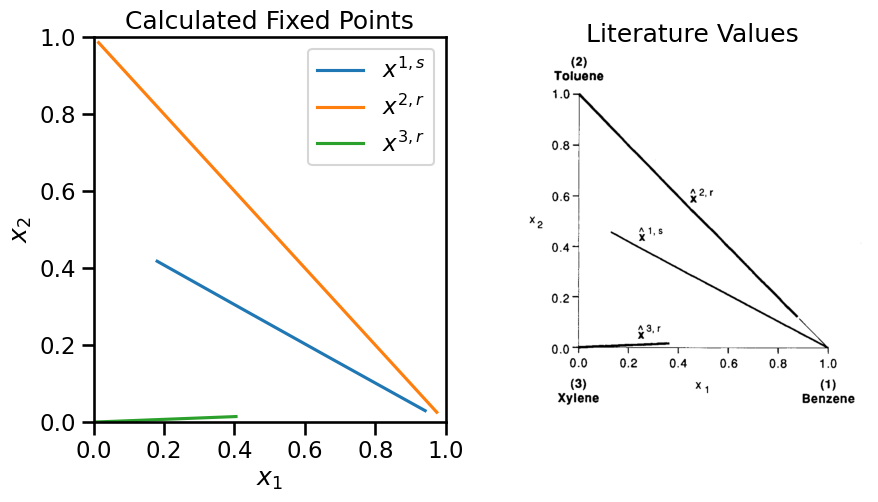

In [47]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].plot(x1s_u1, x1s_u2, label=r'$x^{1,s}$')
ax[0].plot(x2r_u1, x2r_u2, label=r'$x^{2,r}$')
ax[0].plot(x3r_u1, x3r_u2, label=r'$x^{3,r}$')

ax[0].set_xlim((0,1))
ax[0].set_ylim((0,1))
ax[0].set_xlabel(r'$x_1$')
ax[0].set_ylabel(r'$x_2$')
ax[0].set_title('Calculated Fixed Points')
ax[0].legend()
# plt.tight_layout()

img = np.asarray(Image.open('fidkowski_ex2.png'))

ax[1].imshow(img)
ax[1].axis('off')
ax[1].set_title('Literature Values')

plt.show()

As you can see, the results of `Fidkowski et al` is exactly replicated by our method.